# ANN 

### 📘 Notebook Overview: Developing ANN Model

This notebook focuses on building and evaluating a ANN model to predict income levels in the Adult Census dataset. The process includes preprocessing, training, model persistence, and threshold optimization. The following sections are included:

---

### ▪️ Importing Required Packages  
All necessary Python packages and libraries are imported to support preprocessing, modeling, and evaluation tasks.

### ▪️ Data Preprocessing  
Features are encoded and scaled to input into the ANN model.

### ▪️ Training ANN Model  
A ANN classifier is trained on the training data using **GridSearchCV** for hyperparameter tuning. The process is parallelized using the `n_jobs` parameter to optimize computation time and find the best combination of parameters for model performance.

### ▪️ Save the Model  
The trained model is saved using `joblib` for easy reuse without retraining.

### ▪️ Load and Evaluate the Model  
The saved model is reloaded and evaluated on the test set using classification metrics such as accuracy, precision, recall, and F1-score.

### ▪️ Find Best Threshold Value with AUC-PR  
AUC-PR (Area Under the Precision-Recall Curve) is used to identify the optimal threshold for classification, improving the model's performance on the minority class.

---

## Importing Required Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import GlorotUniform, HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, 
    f1_score, 
    average_precision_score, 
    accuracy_score, 
    balanced_accuracy_score,
    precision_recall_curve,
    auc,
)

import time
import random
import os

## Data Preprocessing

In this section, I prepared the data for training the ANN model. The main preprocessing steps were:

#### 1. Loading the Datasets
- Loaded the training and testing datasets that had already undergone imputation and feature selection.

#### 2. Encoding the Target Variable
- Applied `LabelEncoder` to convert the target variable `income` into numeric values (0 and 1), making it compatible with TensorFlow models.

#### 3. Identifying Feature Types
- Identified and separated numeric and categorical columns for appropriate preprocessing.

#### 4. Encoding Categorical Features
- Applied one-hot encoding to convert categorical features into a binary matrix format suitable for model input.

#### 5. Aligning Columns
- Reindexed the test set to match the structure of the training set, filling any missing columns with zeros.

#### 6. Separating Features and Labels
- Split the datasets into input features (`X_train`, `X_test`) and target labels (`y_train`, `y_test`).

#### 7. Standardizing Numeric Features
- Standardized the numeric features using `StandardScaler` to ensure they have a mean of 0 and standard deviation of 1, which helps ANN models converge faster.

#### 8. Converting to NumPy Arrays
- Converted the datasets into NumPy arrays and set the data types (`float32`) to ensure compatibility and optimal performance with TensorFlow models.


In [2]:
# Load datasets
train_df = pd.read_csv("adult_combined_train_80_imputed_feature_selected.csv")
test_df = pd.read_csv("adult_combined_test_20_imputed_feature_selected.csv")

# Encode target variable with LabelEncoder
label_enc = LabelEncoder()
train_df["income"] = label_enc.fit_transform(train_df["income"])
test_df["income"] = label_enc.transform(test_df["income"])

# Identify numeric and categorical features
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).drop("income", axis=1).columns
categorical_cols = train_df.select_dtypes(include=["object"]).columns

# One-Hot Encode categorical features
train_df = pd.get_dummies(train_df, columns=categorical_cols)
test_df = pd.get_dummies(test_df, columns=categorical_cols)

# Align test set columns with train set
test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

# Separate features and labels
X_train = train_df.drop("income", axis=1)
y_train = train_df["income"]
X_test = test_df.drop("income", axis=1)
y_test = test_df["income"]

# Apply StandardScaler to numeric columns
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Convert to NumPy arrays with correct dtypes for TensorFlow
X_train = X_train.to_numpy().astype(np.float32)
X_test = X_test.to_numpy().astype(np.float32)

y_train = y_train.to_numpy().astype(np.float32)  # or np.int32 depending on your model output
y_test = y_test.to_numpy().astype(np.float32)

In [3]:
label_enc.classes_

array(['<=50K', '>50K'], dtype=object)

## Training ANN Model

In this section, I trained an Artificial Neural Network (ANN) using hyperparameter tuning with `GridSearchCV`. The major steps are:

#### 1. Setting Random Seeds
- Set random seeds for NumPy, Python, and TensorFlow to ensure reproducibility of results.

#### 2. Defining the Model Architecture
- Created a `build_model` function to define the ANN architecture:
  - **Input Layer:** Dense layer with 50 neurons, ReLU activation, HeNormal weight initialization, followed by batch normalization and dropout.
  - **Hidden Layer:** Dense layer with 25 neurons, ReLU activation, batch normalization, and dropout.
  - **Output Layer:** Dense layer with 1 neuron and sigmoid activation (for binary classification).
- Supported different optimizers (`adam`, `rmsprop`, `sgd`) with customizable learning rates.

#### 3. Wrapping the Model for GridSearchCV
- Wrapped the Keras model using `KerasClassifier` to make it compatible with `GridSearchCV`.

#### 4. Defining the Hyperparameter Grid
- Defined a wider range of hyperparameters for tuning.

#### 5. Setting Up Early Stopping
- Used the `EarlyStopping` callback to prevent overfitting:
  - Training stops early if the validation loss does not improve for 10 consecutive epochs.

#### 6. Hyperparameter Tuning with GridSearchCV
- Performed a grid search with 3-fold cross-validation (`cv=3`).
- Used `n_jobs=-1` to parallelize the search across all CPU cores and `verbose=1` to monitor the progress.

#### 7. Model Training
- Trained the model with an 80-20 training-validation split (`validation_split=0.2`) and used early stopping.
- Tracked and printed the total training time in both seconds and minutes.



In [4]:
start_time = time.time()

# Set seed
SEED = 999999
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Define model builder
def build_model(optimizer='adam', learning_rate=0.001, dropout_rate=0.1):
    model = Sequential([
        Dense(50, activation='relu', kernel_initializer=HeNormal(), input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        Dense(25, activation='relu', kernel_initializer=HeNormal()),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        Dense(1, activation='sigmoid', kernel_initializer=GlorotUniform())
    ])

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Wrap the model using KerasClassifier
model = KerasClassifier(build_fn=build_model, verbose=0)

# Define parameter grid

'''
ann_params = {
    'epochs': [50, 100],
    'batch_size': [16, 32],
    'optimizer': ['adam', 'rmsprop'],
    'learning_rate': [0.001],
    'dropout_rate': [0.1, 0.3]
}

'''

# Best Parameters (received after the training) 
ann_params = {
    'epochs': [50],
    'batch_size': [32],
    'optimizer': ['rmsprop'],
    'learning_rate': [0.001],
    'dropout_rate': [0.1]
}


# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, restore_best_weights=True)

# GridSearchCV
ann_grid = GridSearchCV(estimator=model, param_grid=ann_params, n_jobs=-1, cv=3, verbose=1)
ann_grid.fit(X_train, y_train, callbacks=[early_stop], validation_split=0.2)

end_time = time.time()
print(f"Training time: {(end_time - start_time):.2f} seconds ({(end_time - start_time)/60:.2f} minutes)")

Fitting 3 folds for each of 1 candidates, totalling 3 fits


<ipython-input-4-723d73b874be>:36: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, verbose=0)


Training time: 53.69 seconds (0.89 minutes)


In [5]:
print("Best parameters found by GridSearchCV:")
print(ann_grid.best_params_)

Best parameters found by GridSearchCV:
{'batch_size': 32, 'dropout_rate': 0.1, 'epochs': 50, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}


## Save the Model

In [6]:
model = ann_grid.best_estimator_.model  # This accesses the underlying Keras model

model.save("ann_model.h5")
print("Model saved as ann_model.h5")

Model saved as ann_model.h5


## Load and Evaluate the Model with Test Data

In this section, I loaded the saved ANN model and evaluated its performance on the test dataset. The main steps were:

#### 1. Loading the Saved Model
- Loaded the trained ANN model from the file `ann_model.h5` using `load_model`.

#### 2. Making Predictions
- Predicted the probabilities (`ann_probs`) for the test set.
- Converted probabilities into binary class predictions (`ann_pred`) by applying a threshold of 0.5.

#### 3. Evaluating the Model
- Evaluated the model using several performance metrics:
  - **Classification Report:** Summarizes precision, recall, f1-score, and support for each class.
  - **Balanced Accuracy Score:** Averages the recall obtained on each class, useful for imbalanced datasets.
  - **Accuracy Score:** Measures the overall proportion of correct predictions.
  - **F1 Score:** Combines precision and recall, especially useful when classes are imbalanced.
  - **AUC-PR (Area Under the Precision-Recall Curve):** Provides a performance measure especially important for imbalanced data.


In [7]:
loaded_ann = load_model("ann_model.h5")

ann_probs = loaded_ann.predict(X_test).flatten()
ann_pred = (ann_probs > 0.5).astype(int)

# 9. Print results
print("\n📊 Classification Report:\n", classification_report(y_test, ann_pred, target_names=label_enc.classes_))
print("✅ Balanced Accuracy Score:", balanced_accuracy_score(y_test, ann_pred))
print("✔️ Accuracy:", accuracy_score(y_test, ann_pred))
print("🎯 F1 Score:", f1_score(y_test, ann_pred))
print("📈 AUC-PR:", average_precision_score(y_test, ann_probs))

301/301 [==============================] - 0s 512us/step

📊 Classification Report:
               precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      7310
        >50K       0.74      0.64      0.68      2295

    accuracy                           0.86      9605
   macro avg       0.81      0.78      0.80      9605
weighted avg       0.85      0.86      0.86      9605

✅ Balanced Accuracy Score: 0.7834118660384051
✔️ Accuracy: 0.8589276418532015
🎯 F1 Score: 0.6839281548868673
📈 AUC-PR: 0.7796532034101312


## Find Best Threshold Value with AUC-PR

In this section, I analyzed the model's precision-recall performance and selected the best decision threshold to maximize the F1 score. The main steps were:

#### 1. Calculate Precision, Recall, and Thresholds
- Used `precision_recall_curve` to compute precision, recall, and threshold values based on the model's predicted probabilities.

#### 2. Calculate AUC-PR
- Computed the **Area Under the Precision-Recall Curve (AUC-PR)** using the `auc` function.

#### 3. Find the Best Threshold
- Calculated the F1 score at each threshold.
- Identified the threshold that gave the **highest F1 score**, indicating the best balance between precision and recall.

#### 4. Visualize the Precision-Recall Curve
- Plotted the precision-recall curve.
- Highlighted the point corresponding to the best threshold to visualize where the model performs best.

#### 5. Apply the Best Threshold
- Converted predicted probabilities into binary class predictions based on the best threshold.
- Re-evaluated model performance using:
  - **Classification Report** (precision, recall, F1-score)
  - **Balanced Accuracy Score**
  - **Accuracy**
  - **F1 Score**

Using a custom threshold (instead of the default 0.5) helps to better optimize model performance, especially in cases of class imbalance.

📈 AUC-PR (using auc): 0.7796006603164347

🔥 Best Threshold = 0.3835
🎯 Best F1 Score = 0.7034


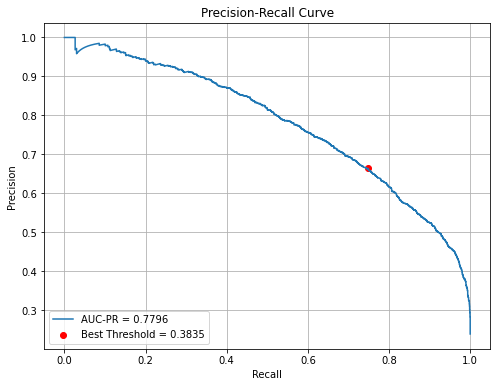


📊 Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.88      0.90      7310
         1.0       0.66      0.75      0.70      2295

    accuracy                           0.85      9605
   macro avg       0.79      0.81      0.80      9605
weighted avg       0.86      0.85      0.85      9605

✅ Balanced Accuracy Score: 0.8145665501342656
✔️ Accuracy: 0.8492451847995836
🎯 F1 Score: 0.7034002458009013


In [8]:
# Calculate precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, ann_probs)

# Calculate AUC-PR and Average Precision
auc_pr = auc(recall, precision)

print("📈 AUC-PR (using auc):", auc_pr)

# Calculate F1 scores for each threshold (length of thresholds = len(precision) - 1)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n🔥 Best Threshold = {best_threshold:.4f}")
print(f"🎯 Best F1 Score = {best_f1:.4f}")

# 4. Plot PR Curve and mark best threshold
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.4f}')
plt.scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best Threshold = {best_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

# Apply best threshold to get predicted class labels
y_pred_best = (ann_probs >= best_threshold).astype(int)

# 6. Print classification report using best threshold
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_best))
print("✅ Balanced Accuracy Score:", balanced_accuracy_score(y_test, y_pred_best))
print("✔️ Accuracy:", accuracy_score(y_test, y_pred_best))
print("🎯 F1 Score:", f1_score(y_test, y_pred_best))